<a href="https://colab.research.google.com/github/Interaverse/Forecasting-monthly-copper-prices/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the datasets by uploading the files to "files" section on Google Collab
train_data = pd.read_excel('training_data-11.xlsx') # Rename if needed
test_data = pd.read_excel('testing_data-11.xlsx') # Rename if needed

# Set 'Copper_Price' as the target column to use
train_scaled = train_data['Price_Copper'].values.reshape(-1,1)
test_scaled = test_data['Price_Copper'].values.reshape(-1,1)

In [ ]:
import numpy as np  # Import numpy library

# This function is optional, but it improves performance
def create_dataset(dataset, time_step=10):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # Extracting time_step consecutive elements
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Corresponding future value as label
    return np.array(dataX), np.array(dataY)

# Initialize time step
time_step = 10
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)


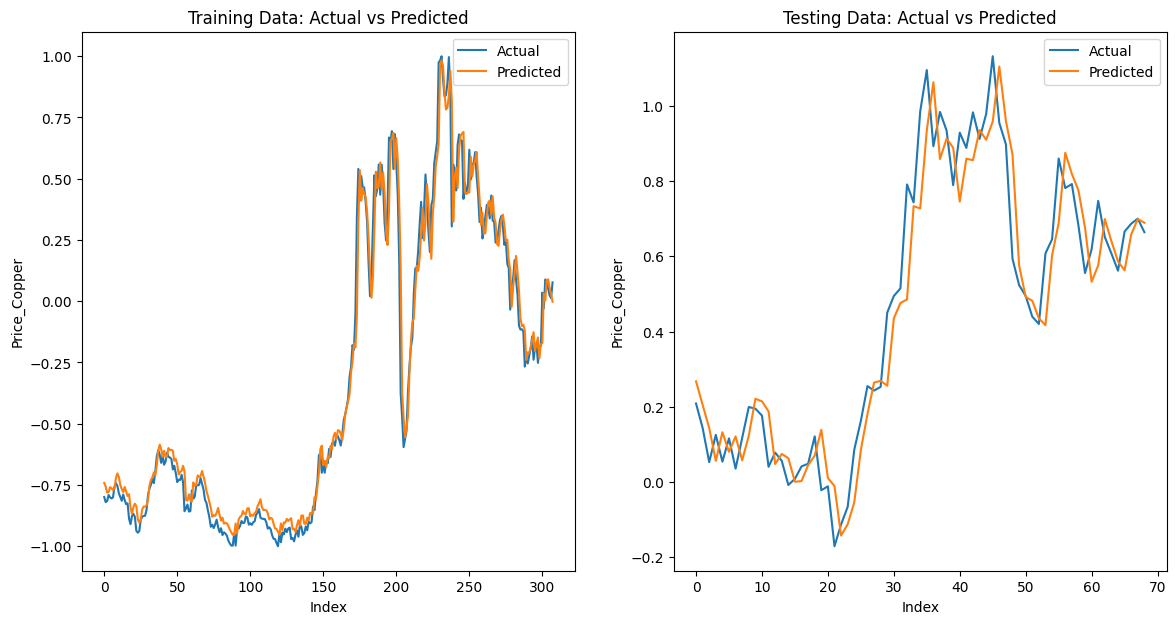

Training RMSE: 0.09074576509528429, R2: 0.9767010560740808
Testing RMSE: 0.10744125615957796, R2: 0.9116023435943849


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and train the SVR model
svr_model = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)

# Calculate RMSE and R2 Score for training and testing sets
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Plotting the actual vs predicted values for training and testing sets
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Price_Copper')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Testing Data: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Price_Copper')
plt.legend()

plt.show()

# Output RMSE and R2 Score
print(f"Training RMSE: {train_rmse}, R2: {train_r2}")
print(f"Testing RMSE: {test_rmse}, R2: {test_r2}")

In [ ]:
!pip install deap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms

def evaluate_individual(individual):
    # Unpack individual's parameters for SVM
    C, epsilon, kernel = individual
    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model.fit(X_train, y_train.ravel())  # Use ravel() to ensure y_train is the correct shape
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return (mse, rmse)

def mutate_individual(individual):
    if random.random() < 0.2:
        individual[0] = random.uniform(0.1, 100)  # Vary C
    if random.random() < 0.2:
        individual[1] = random.uniform(0.01, 1)  # Vary epsilon
    if random.random() < 0.2:
        individual[2] = random.choice(["linear", "poly", "rbf", "sigmoid"])  # Vary kernel
    return individual,

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_C", random.uniform, 0.1, 100)
toolbox.register("attr_epsilon", random.uniform, 0.01, 1)
toolbox.register("attr_kernel", random.choice, ["linear", "poly", "rbf", "sigmoid"])
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_epsilon, toolbox.attr_kernel),
                 n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm process
population = toolbox.population(n=30)
ngen = 10
for gen in range(ngen):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Display the best individual
best_individual = tools.selBest(population, k=1)[0]
print("Best individual found:")
print(f"Parameters: C={best_individual[0]}, epsilon={best_individual[1]}, kernel={best_individual[2]}")
print(f"MSE: {best_individual.fitness.values[0]}, RMSE: {best_individual.fitness.values[1]}")


Best individual found:
Parameters: C=7.2874700389047025, epsilon=0.15791444785924125, kernel=linear
MSE: 0.01049686539265436, RMSE: 0.10245421120019596


# Best Model: DEAP Params

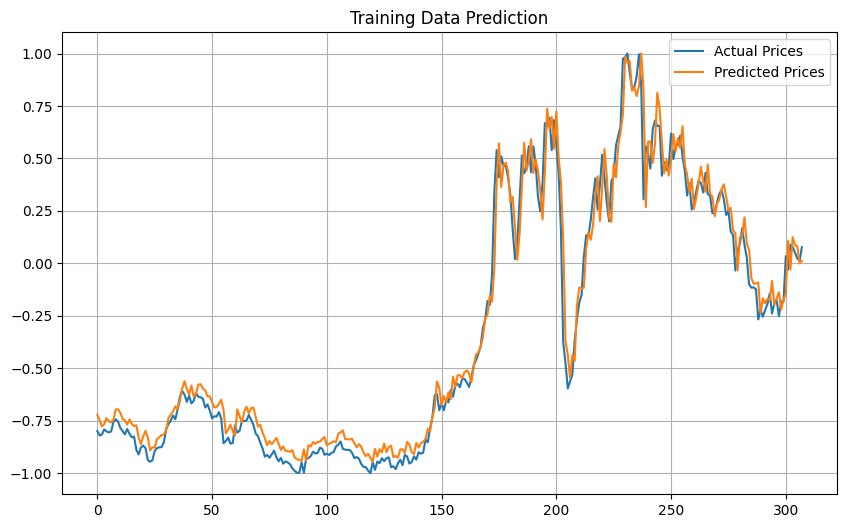

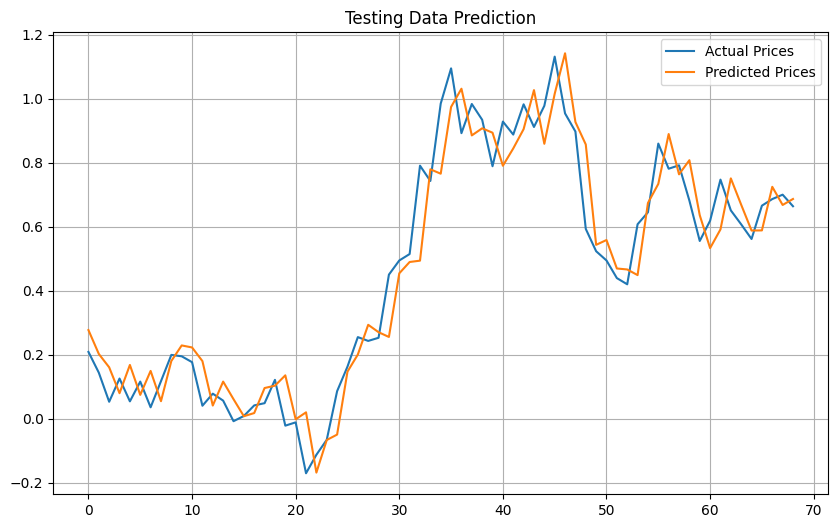

--------------------------
MSE: 0.01049686539265436
--------------------------
RMSE: 0.10245421120019596
--------------------------
MAE: 0.08121697349379739
--------------------------
R^2 Score: 0.9196181079282078
--------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Best individual parameters from DEAP
best_params = {'C': best_individual[0], 'epsilon': best_individual[1], 'kernel': best_individual[2]}

# Initialize and fit the model with the best parameters
model = SVR(C=best_params['C'], epsilon=best_params['epsilon'], kernel=best_params['kernel'])
model.fit(X_train, y_train.ravel())  # Assuming X_train and y_train are preloaded and processed

# Predicting and evaluating
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

# Plotting the actual vs predicted prices for training data
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual Prices')
plt.plot(train_predict, label='Predicted Prices')
plt.title('Training Data Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the actual vs predicted prices for testing data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(test_predict, label='Predicted Prices')
plt.title('Testing Data Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Output the scores
print('--------------------------')
print(f"MSE: {mse}")
print('--------------------------')
print(f"RMSE: {rmse}")
print('--------------------------')
print(f"MAE: {mae}")
print('--------------------------')
print(f"R^2 Score: {r2}")
print('--------------------------')


# **Cross-Validation: DEAP Params**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
import numpy as np

# Best DEAP parameters (simulate fetching these from DEAP's output)
deap_best_C = best_individual[0]
deap_best_epsilon = best_individual[1]
deap_best_kernel = best_individual[2]

# Prepare the time series cross-validator
tscv = TimeSeriesSplit(n_splits=10)

# Create an SVR model
model = SVR()

# Define the parameter grid based on the initial DEAP optimization results
param_grid = {
    'C': [deap_best_C],            # DEAP suggested C
    'epsilon': [deap_best_epsilon],  # DEAP suggested epsilon
    'kernel': [deap_best_kernel],  # DEAP suggested kernel
}

# Setup GridSearchCV to find the best parameters using the defined cross-validator
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', verbose=1)

# Assume X_train, y_train are defined with your actual dataset
grid_search.fit(X_train, y_train)

# Output the best parameters and the corresponding RMSE for the best model
best_params = grid_search.best_params_
best_cv_score = np.sqrt(-grid_search.best_score_)
print(f"Best parameters: {best_params}")
print(f"Best cross-validation RMSE: {best_cv_score}")

# Using the best estimator to make predictions on each fold and evaluate additional metrics
best_model = grid_search.best_estimator_

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Directly predict using the best model
    predictions = best_model.predict(X_test_fold)
    rmse = np.sqrt(mean_squared_error(y_test_fold, predictions))
    mae = mean_absolute_error(y_test_fold, predictions)
    r2 = r2_score(y_test_fold, predictions)
    print(f'Fold RMSE: {rmse}, Fold MAE: {mae}, Fold R2: {r2}')


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'C': 7.2874700389047025, 'epsilon': 0.15791444785924125, 'kernel': 'linear'}
Best cross-validation RMSE: 0.18390091006666442
Fold RMSE: 0.05781091221703626, Fold MAE: 0.047129753049920654, Fold R2: 0.35966883447684495
Fold RMSE: 0.06562532480852196, Fold MAE: 0.060782401798708294, Fold R2: 0.1819685499247301
Fold RMSE: 0.05762935239486668, Fold MAE: 0.05328205943672004, Fold R2: -0.9181151174167348
Fold RMSE: 0.06302404770348802, Fold MAE: 0.0568716012001828, Fold R2: -6.601927927952826
Fold RMSE: 0.047200684794727304, Fold MAE: 0.03710407271641386, Fold R2: 0.8825855320787492
Fold RMSE: 0.13512877130802123, Fold MAE: 0.10967859992845241, Fold R2: 0.7479181418940157
Fold RMSE: 0.14809177015684158, Fold MAE: 0.11834821148167904, Fold R2: 0.8620126489147586
Fold RMSE: 0.15929115669762173, Fold MAE: 0.11870029877482371, Fold R2: 0.40218701911035026
Fold RMSE: 0.07931665588138985, Fold MAE: 0.062409979084977585,

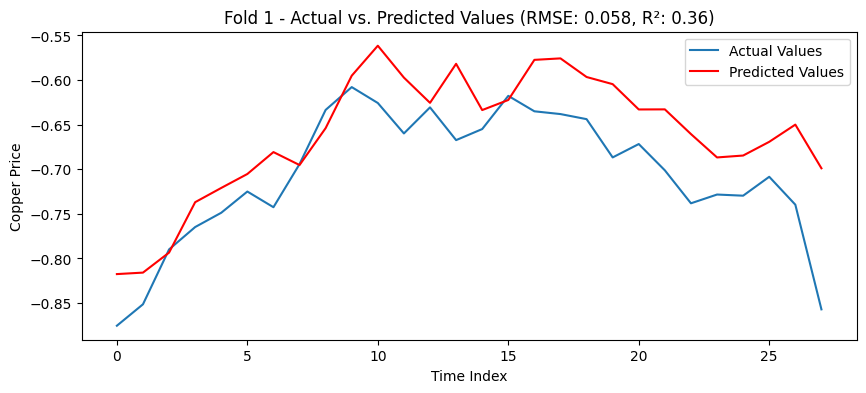

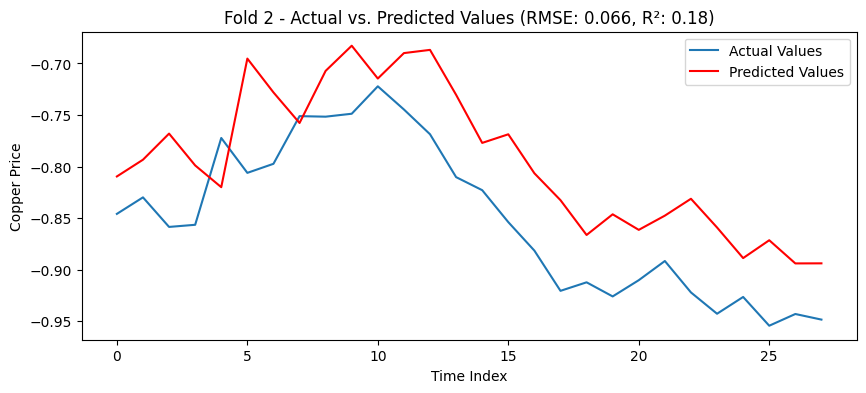

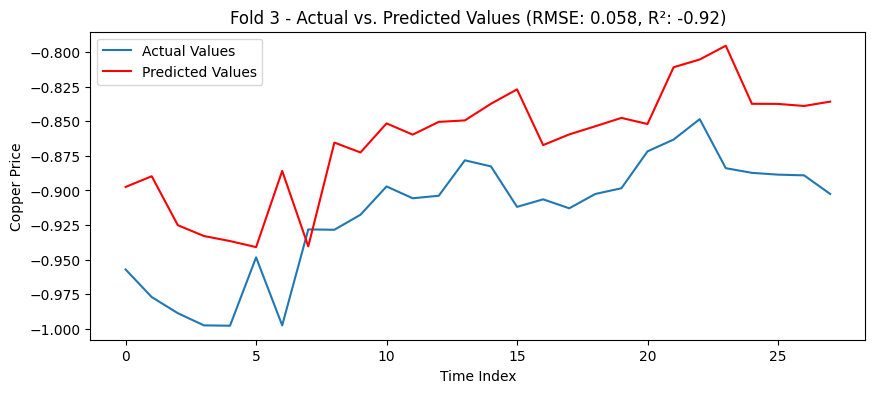

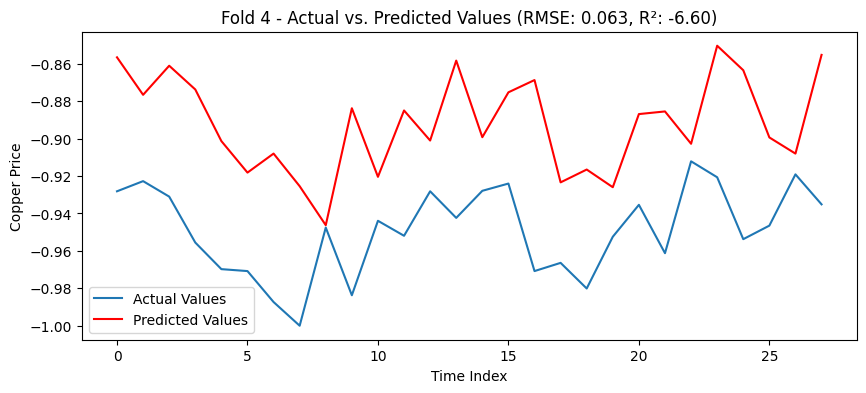

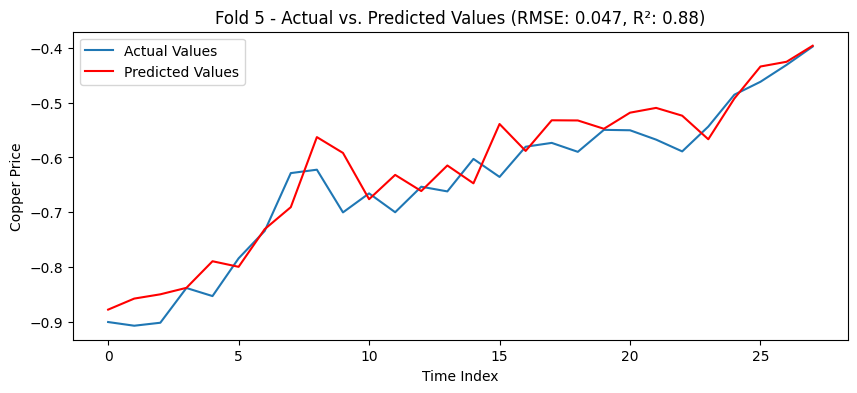

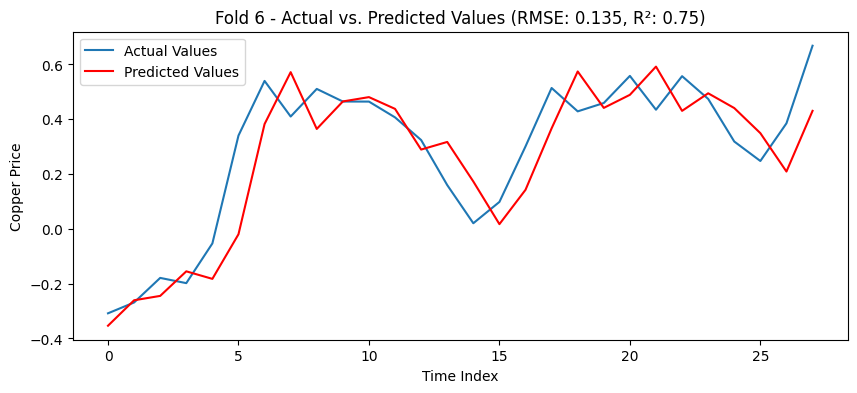

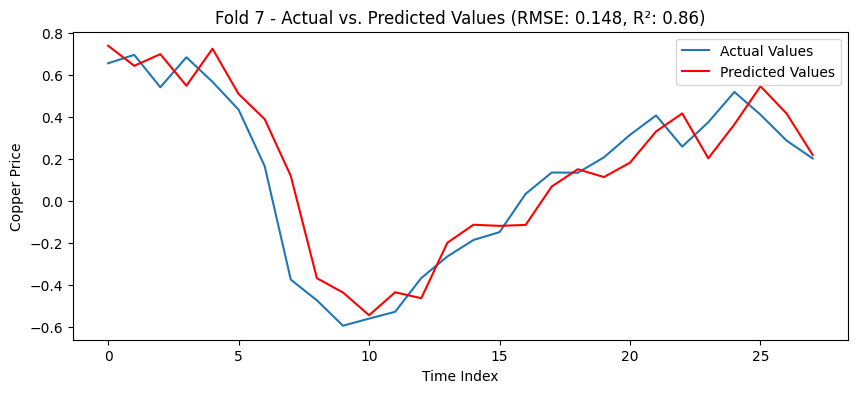

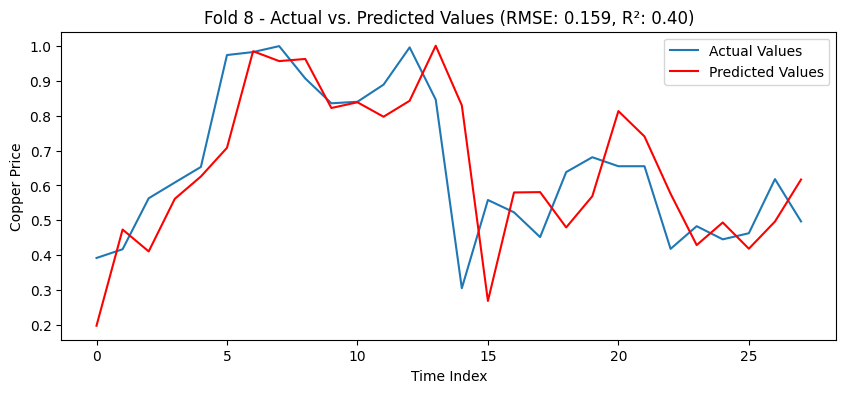

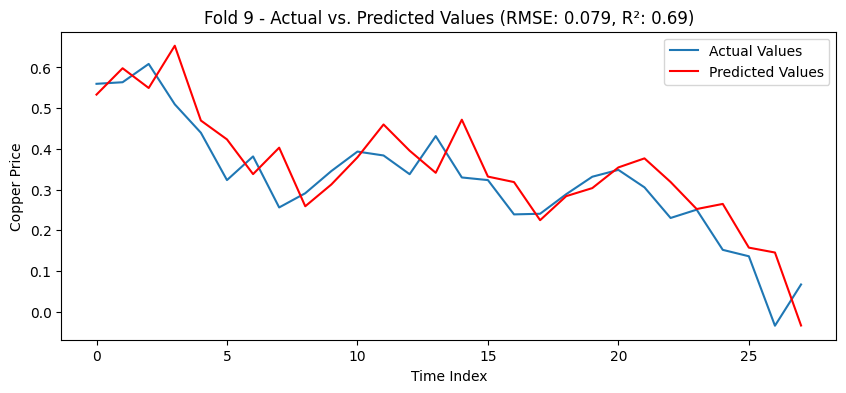

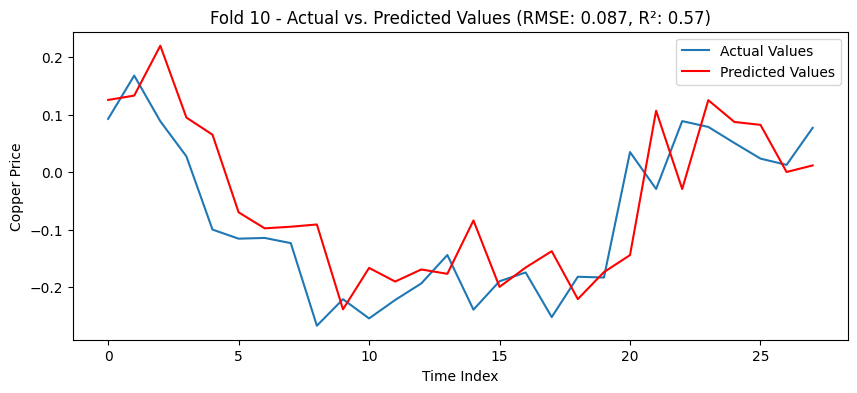

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

best_model = grid_search.best_estimator_

# Loop through each fold in the Time Series Split
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Predict using the best model
    fold_predictions = best_model.predict(X_test_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_test_fold, fold_predictions))
    fold_r2 = r2_score(y_test_fold, fold_predictions)  # Calculate R^2 score

    # Plotting the results for the current fold
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_fold, label='Actual Values')
    plt.plot(fold_predictions, 'r', label='Predicted Values')
    plt.title(f'Fold {i+1} - Actual vs. Predicted Values (RMSE: {fold_rmse:.3f}, R²: {fold_r2:.2f})')
    plt.xlabel('Time Index')
    plt.ylabel('Copper Price')
    plt.legend()
    plt.show()
